# 3.2 ロボットの動き

## 3.2.1 世界座標系と描写

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
class World :
  def __init__(self):
    self.objects = [] #ここにロボットなどのオブジェクトを登録

  def append(self, obj): #オブジェクトを登録するための関数
    self.objects.append(obj)

  def draw(self):
    fig = plt.figure(figsize=(8,8)) #8*8 inchの図を準備
    ax = fig.add_subplot(111) #サブプロットを準備 111は描画の大きさかな
    ax.set_aspect('equal') #縦横比を座標の値と一致させる
    ax.set_xlim(-5,5) #x軸を-5 * 5mの範囲で描画
    ax.set_ylim(-5, 5) #y軸も同様
    ax.set_xlabel("X", fontsize=20) #X軸にラベルを表示
    ax.set_ylabel("Y", fontsize=20) #Y軸も同様

    for obj in self.objects:obj.draw(ax) #appendした物体を次々に描画

    plt.show()



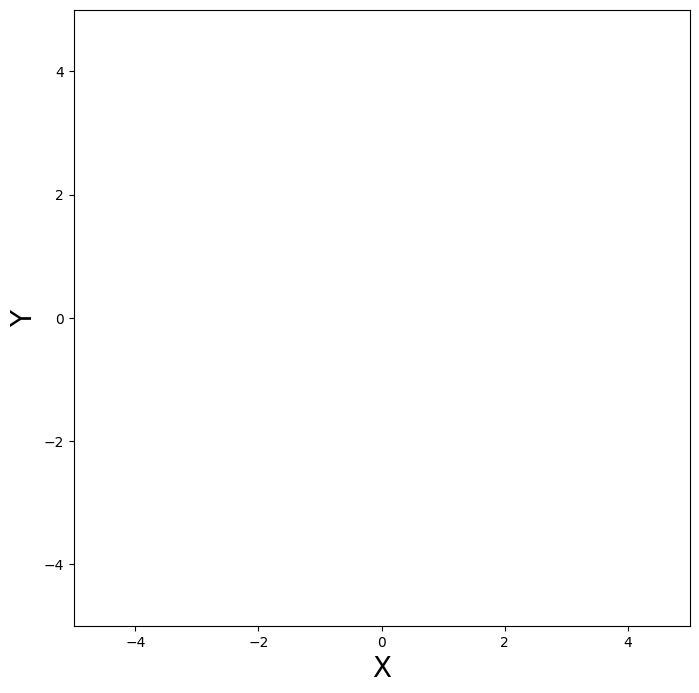

In [ ]:
world = World()
world.draw()

## 3.2.2 ロボットの姿勢と描画

In [ ]:
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np

In [ ]:
class IdealRobot:                                        # fig:idealrobot
    def __init__(self, pose, color="black"):
        self.pose = pose        # 引数から姿勢の初期値を設定
        self.r = 0.2            # これは描画のためなので固定値
        self.color = color      # 引数から描画するときの色を設定

    def draw(self, ax):
      x, y, theta = self.pose #姿勢の変数を分解して3つの変数へ
      xn = x + self.r * math.cos(theta) #ロボットの鼻先のx座標
      yn = y + self.r* math.sin(theta) #ロボットの鼻先のy座標
      ax.plot([x,xn], [y,yn], color = self.color) #ロボットの向きを示す線分の描写
      c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color)
      ax.add_patch(c) #上のpatches.Circleでロボットの胴体を示す円を作ってサブプロットへ登録


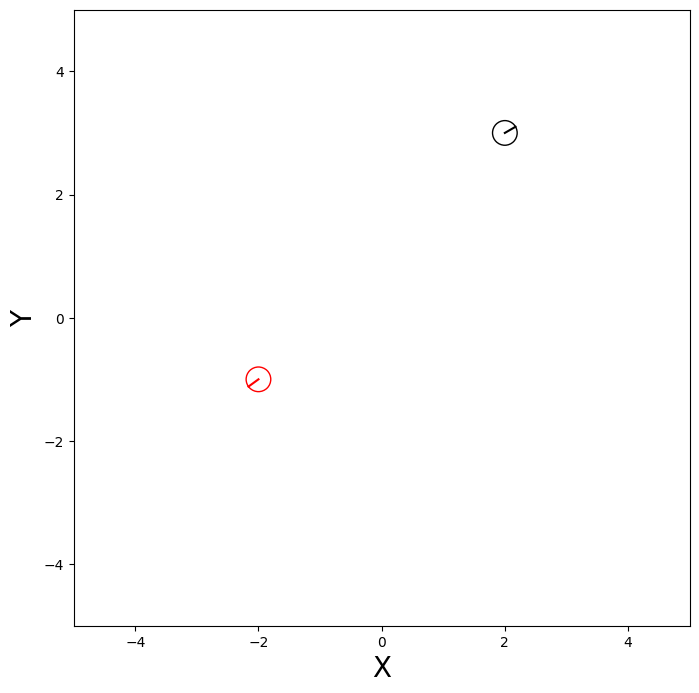

In [ ]:
world = World()

robot1 = IdealRobot(np.array([2, 3, math.pi/6]).T)
robot2 = IdealRobot(np.array([-2, -1, math.pi/5*6]).T , "red")
world.append(robot1)
world.append(robot2)

world.draw()

## 3.2.3 アニメーションの導入

In [ ]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
from IPython.display import HTML

In [ ]:
class World:
  def __init__(self, debug=False):
    self.objects = []
    self.debug = debug

  def append(self, obj):
    self.objects.append(obj)

  def draw(self):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xlabel("X", fontsize=10)
    ax.set_ylabel("Y", fontsize=10)

    elems = []
    time_increment = 0.1

    if self.debug:
      for i in range(1000): self.one_step(i, elems, ax)
    else:
      self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax), frames=10, interval=1000, repeat=False)
      return HTML(self.ani.to_jshtml())

  def one_step(self, i, elems, ax):
    while elems: elems.pop().remove()
    elems.append(ax.text(-4.4, 4.5, "t = " + str(i), fontsize=10))
    for obj in self.objects:
      obj.draw(ax, elems)

In [ ]:
class IdealRobot:
  def __init__(self, pose, color="black"):
    self.pose = pose
    self.r = 0.2
    self.color = color


  def draw(self, ax, elems):#実際はオブジェクトをelemsに追加する関数となってる
    x, y, theta = self.pose
    xn = x + self.r * math.cos(theta)
    yn = y + self.r * math.sin(theta)
    elems += ax.plot([x,xn], [y, yn], color = self.color) #elems += を追加
    c= patches.Circle(xy=(x, y), radius = self.r, fill=False, color = self.color) #c= を追加
    elems.append(ax.add_patch(c)) # elem.apendで包む

In [ ]:
world = World(debug=False)

robot1 = IdealRobot(np.array([2, 3, math.pi/6]).T)
robot2 = IdealRobot(np.array([-2, -1, math.pi/5*6]).T , "red")
world.append(robot1)
world.append(robot2)

world.draw()

<IPython.core.display.Javascript object>

## 3.2.4 ロボットの運動と状態方程式

In [ ]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
from IPython.display import HTML

状態遷移関数


*   clsはclassmethodのためのselfと同じ引数
*   nu->速度
*   omega-.角振動数
*   pose ->t=t-1での前の姿勢を示す



In [ ]:
class IdealRobot:
  def __init__(self, pose, color="black"):
    self.pose = pose
    self.r = 0.2
    self.color = color


  def draw(self, ax, elems):#実際はオブジェクトをelemsに追加する関数となってる
    x, y, theta = self.pose
    xn = x + self.r * math.cos(theta)
    yn = y + self.r * math.sin(theta)
    elems += ax.plot([x,xn], [y, yn], color = self.color) #elems += を追加
    c= patches.Circle(xy=(x, y), radius = self.r, fill=False, color = self.color) #c= を追加
    elems.append(ax.add_patch(c)) # elem.apendで包む

  @classmethod
  def state_transition(cls, nu, omega, time, pose):
    t0 = pose[2]
    if math.fabs(omega) < 1e-10:
      return pose + np.array([nu*math.cos(t0),
                              nu*math.sin(t0),
                              omega]) * time
    else:
      return pose + np.array([nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)),
                              nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                              omega*time])

In [ ]:
# 原点から0.1[m/s]で1[s]直進 ##          ### fig:using_state_transition（セル6まで）
IdealRobot.state_transition(0.1, 0.0, 1.0, np.array([0,0,0]).T)

array([0.1, 0. , 0. ])

In [ ]:
## 原点から0.1[m/s], 10[deg/s]で9[s]移動 ##
IdealRobot.state_transition(0.1, 10.0/180*math.pi, 9.0, np.array([0,0,0]).T)

array([0.5729578 , 0.5729578 , 1.57079633])

## 3.2.5 エージェントの実装

In [ ]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
from IPython.display import HTML

In [54]:
class Agent:
  def __init__(self, nu, omega):
    self.nu = nu
    self.omega = omega

  def decision(self, observation=None):
    return self.nu, self.omega

In [ ]:
class IdealRobot:
  def __init__(self, pose, agent = None, color="black"):
    self.pose = pose
    self.r = 0.2
    self.agent = agent
    self.color = color

    self.poses = [pose]

  def draw(self, ax, elems):#実際はオブジェクトをelemsに追加する関数となってる
    x, y, theta = self.pose
    xn = x + self.r * math.cos(theta)
    yn = y + self.r * math.sin(theta)
    elems += ax.plot([x,xn], [y, yn], color = self.color) #elems += を追加
    c= patches.Circle(xy=(x, y), radius = self.r, fill=False, color = self.color) #c= を追加
    elems.append(ax.add_patch(c)) # elem.apendで包む

    self.poses.append(self.pose) #以下追加。軌跡の描画
    elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color = "black")

  @classmethod
  def state_transition(cls, nu, omega, time, pose):
    t0 = pose[2]
    if math.fabs(omega) < 1e-10:
      return pose + np.array([nu*math.cos(t0),
                              nu*math.sin(t0),
                              omega]) * time
    else:
      return pose + np.array([nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)),
                              nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                              omega*time])



In [48]:
world = World()                                                                                                                       ### fig:rewrite_robot_for_agent
straight = Agent(0.2, 0.0)                # 0.2[m/s]で直進
circling = Agent(0.2, 10.0/180*math.pi)   # 0.2[m/s], 10[deg/s]（円を描く）
robot1 = IdealRobot( np.array([ 2, 3, math.pi/6]).T,    straight )
robot2 = IdealRobot( np.array([-2, -1, math.pi/5*6]).T, circling, "red")
robot3 = IdealRobot( np.array([ 0, 0, 0]).T, color="blue")     # エージェントを与えないロボット
world.append(robot1)
world.append(robot2)
world.append(robot3)
world.draw()


<IPython.core.display.Javascript object>

In [66]:
class World:
  def __init__(self, debug=False):
    self.objects = []
    self.debug = debug

  def append(self, obj):
    self.objects.append(obj)

  def draw(self):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xlabel("X", fontsize=10)
    ax.set_ylabel("Y", fontsize=10)

    elems = []
    time_increment = 0.1

    if self.debug:
      for i in range(1000): self.one_step(i, elems, ax)
    else:
      self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax), frames=100, interval=1000, repeat=False)
      return HTML(self.ani.to_jshtml())

  def one_step(self, i, elems, ax):
    while elems: elems.pop().remove()
    elems.append(ax.text(-4.4, 4.5, "t = " + str(i), fontsize=10))
    for obj in self.objects:
      obj.draw(ax, elems)
      if hasattr(obj, "one_step"): obj.one_step(1.0) #追加

In [62]:
class IdealRobot:
  def __init__(self, pose, agent = None, color="black"):
    self.pose = pose
    self.r = 0.2
    self.agent = agent
    self.color = color

    self.poses = [pose]

  def draw(self, ax, elems):#実際はオブジェクトをelemsに追加する関数となってる
    x, y, theta = self.pose
    xn = x + self.r * math.cos(theta)
    yn = y + self.r * math.sin(theta)
    elems += ax.plot([x,xn], [y, yn], color = self.color) #elems += を追加
    c= patches.Circle(xy=(x, y), radius = self.r, fill=False, color = self.color) #c= を追加
    elems.append(ax.add_patch(c)) # elem.apendで包む

    self.poses.append(self.pose)
    elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color = "black")

  @classmethod
  def state_transition(cls, nu, omega, time, pose):
    t0 = pose[2]
    if math.fabs(omega) < 1e-10:
      return pose + np.array([nu*math.cos(t0),
                              nu*math.sin(t0),
                              omega]) * time
    else:
      return pose + np.array([nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)),
                              nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                              omega*time])

def one_step(self, time_interval):#追加
    if not self.agent: return
    obs = self.observation(time_interval)
    nu, omega = self.agent.decision(obs)
    self.pose = self.state_transition(nu, omega, time_interval, self.pose)

In [63]:
class Agent:
  def __init__(self, nu, omega):
    self.nu = nu
    self.omega = omega

  def decision(self, observation=None):
    return self.nu, self.omega

In [65]:
world = World()                                                                                                                       ### fig:rewrite_robot_for_agent
straight = Agent(0.2, 0.0)                # 0.2[m/s]で直進
circling = Agent(0.2, 10.0/180*math.pi)   # 0.2[m/s], 10[deg/s]（円を描く）
robot1 = IdealRobot( np.array([ 2, 3, math.pi/6]).T,    straight )
robot2 = IdealRobot( np.array([-2, -1, math.pi/5*6]).T, circling, "red")
robot3 = IdealRobot( np.array([ 0, 0, 0]).T, color="blue")     # エージェントを与えないロボット
world.append(robot1)
world.append(robot2)
world.append(robot3)
world.draw()


<IPython.core.display.Javascript object>

## 3.2.6 離散時刻の設定

# 3.3 ロボットの観測

## 3.3.1 点ランドマークの設置

## 3.3.2 点ランドマークの観測

# 3.4 コードの保存と再利用